## Model

In [ ]:
#kaggle: https://www.kaggle.com/code/tcc3281/traffic-signs-classification

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd

In [2]:
!nvidia-smi

Wed Mar  5 17:24:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [4]:
# Tham số
IMG_SIZE = (224, 224)  # Điều chỉnh theo kích thước ảnh của bạn
BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 15  # Thay đổi theo số lượng class thực tế

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

TRAIN_PATH='/kaggle/input/traffic-signs/dataset/train'
VAL_PATH='/kaggle/input/traffic-signs/dataset/val'
TEST_PATH='/kaggle/input/traffic-signs/dataset/test'
MODEL_PATH='/kaggle/input/base_vgg/tensorflow2/default/1/best_model_v19.keras'

In [5]:
# Tạo data generators
train_datagen = ImageDataGenerator(
    rescale=1./224,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./224)

# Tạo data loaders
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 52500 images belonging to 15 classes.
Found 11250 images belonging to 15 classes.
Found 11250 images belonging to 15 classes.


In [6]:
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True
)

# Use the learning rate schedule in the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

In [7]:
checkpoint = ModelCheckpoint('best_model_v20.keras', monitor='val_loss', save_best_only=True, mode='min')

In [8]:
# read Model
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
# from keras import layers

# model = Sequential()
# for layer in base_model.layers:
#     model.add(layer)
#     if isinstance(layer, layers.Conv2D):
#         model.add(layers.BatchNormalization())
#         model.add(layers.Activation('relu'))

# # Thêm các lớp Fully Connected mới
# model.add(layers.Flatten())
# model.add(layers.Dense(1024))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dense(512))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [10]:
model=tf.keras.models.load_model(MODEL_PATH)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 53,274,478 (203.23 MB)

 Trainable params: 12,853,263 (49.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 25,706,527 (98.06 MB)

In [12]:
# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [13]:
# Train model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


821/821 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - categorical_accuracy: 0.9293 - loss: 0.2063 - precision: 0.9653 - recall: 0.8989 - val_categorical_accuracy: 0.9411 - val_loss: 0.1926 - val_precision: 0.9695 - val_recall: 0.9093
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 810s 980ms/step - categorical_accuracy: 0.9309 - loss: 0.1988 - precision: 0.9668 - recall: 0.9023 - val_categorical_accuracy: 0.9358 - val_loss: 0.1888 - val_precision: 0.9672 - val_recall: 0.9104
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 768s 928ms/step - categorical_accuracy: 0.9336 - loss: 0.1956 - precision: 0.9671 - recall: 0.9046 - val_categorical_accuracy: 0.9343 - val_loss: 0.1969 - val_precision: 0.9634 - val_recall: 0.9072
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 757s 914ms/step - categorical_accuracy: 0.9372 - loss: 0.1835 - precision: 0.9675 - recall: 0.9112 - val_categorical_accuracy: 0.9404 - val_loss: 0.1813 - val_precision: 0.9692 - val_recall: 0.9153
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 764s 923ms/step - cat

In [14]:
# Save model
# Lưu model
model.save('image_classifier_v20.h5')

## Evaluate

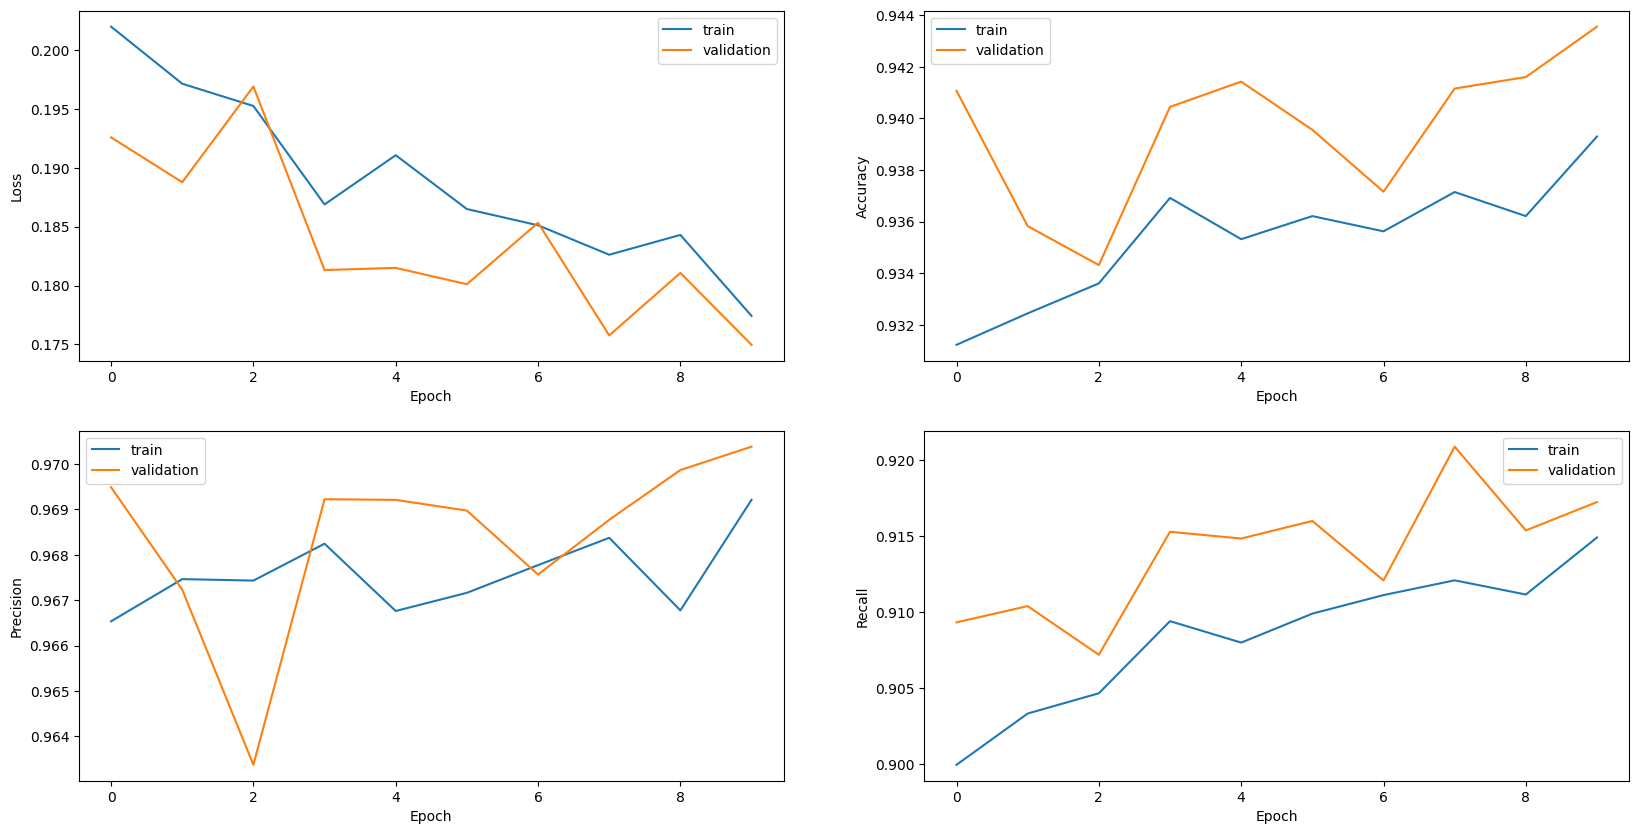

In [15]:
# Plot loss, accuracy, precision, and recall
plt.figure(figsize=(20, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [16]:
# Evaluate model
train_loss, train_accuracy, train_precision, train_recall = model.evaluate(train_generator)
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

821/821 ━━━━━━━━━━━━━━━━━━━━ 681s 829ms/step - categorical_accuracy: 0.9407 - loss: 0.1751 - precision: 0.9709 - recall: 0.9156
176/176 ━━━━━━━━━━━━━━━━━━━━ 52s 294ms/step - categorical_accuracy: 0.9449 - loss: 0.1685 - precision: 0.9713 - recall: 0.9195
176/176 ━━━━━━━━━━━━━━━━━━━━ 123s 702ms/step - categorical_accuracy: 0.9608 - loss: 0.1179 - precision: 0.9779 - recall: 0.9510


In [17]:
# Create DataFrame to display results
results = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Loss': [train_loss, val_loss, test_loss],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy],
    'Precision': [train_precision, val_precision, test_precision],
    'Recall': [train_recall, val_recall, test_recall]
})

# Print results table
print(results)

          Set      Loss  Accuracy  Precision    Recall
0       Train  0.174532  0.940952   0.971312  0.915771
1  Validation  0.174967  0.943556   0.970378  0.917244
2        Test  0.185772  0.938133   0.968497  0.915467


176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 285ms/step


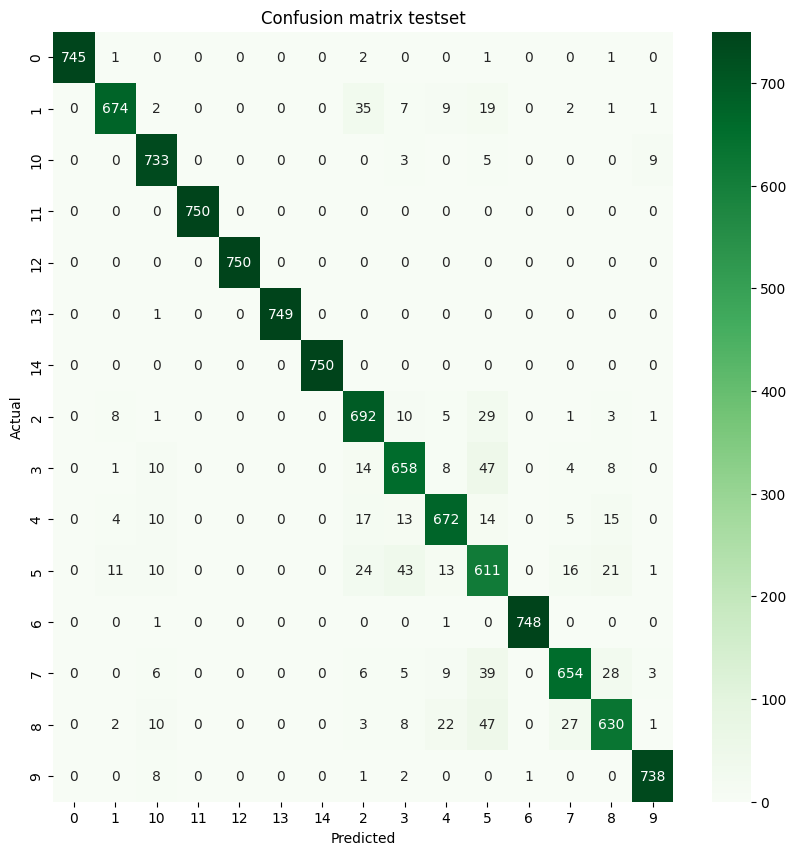

In [18]:
# Dự đoán
test_Y_pred = model.predict(test_generator)
test_y_pred = np.argmax(test_Y_pred, axis=1)

# Labels
test_labels = test_generator.class_indices
test_labels = dict((v, k) for k, v in test_labels.items())
test_predictions = [test_labels[k] for k in test_y_pred]

# Thực tế
test_y_test = test_generator.classes
test_true_labels = [test_labels[k] for k in test_y_test]

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions, labels=list(test_labels.values()))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(test_labels.values()), yticklabels=list(test_labels.values()), cmap='Greens')
plt.title('Confusion matrix testset')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
print(classification_report(test_true_labels, test_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       750
           1       0.96      0.90      0.93       750
          10       0.93      0.98      0.95       750
          11       1.00      1.00      1.00       750
          12       1.00      1.00      1.00       750
          13       1.00      1.00      1.00       750
          14       1.00      1.00      1.00       750
           2       0.87      0.92      0.90       750
           3       0.88      0.88      0.88       750
           4       0.91      0.90      0.90       750
           5       0.75      0.81      0.78       750
           6       1.00      1.00      1.00       750
           7       0.92      0.87      0.90       750
           8       0.89      0.84      0.86       750
           9       0.98      0.98      0.98       750

    accuracy                           0.94     11250
   macro avg       0.94      0.94      0.94     11250
weighted avg       0.94   

176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 283ms/step


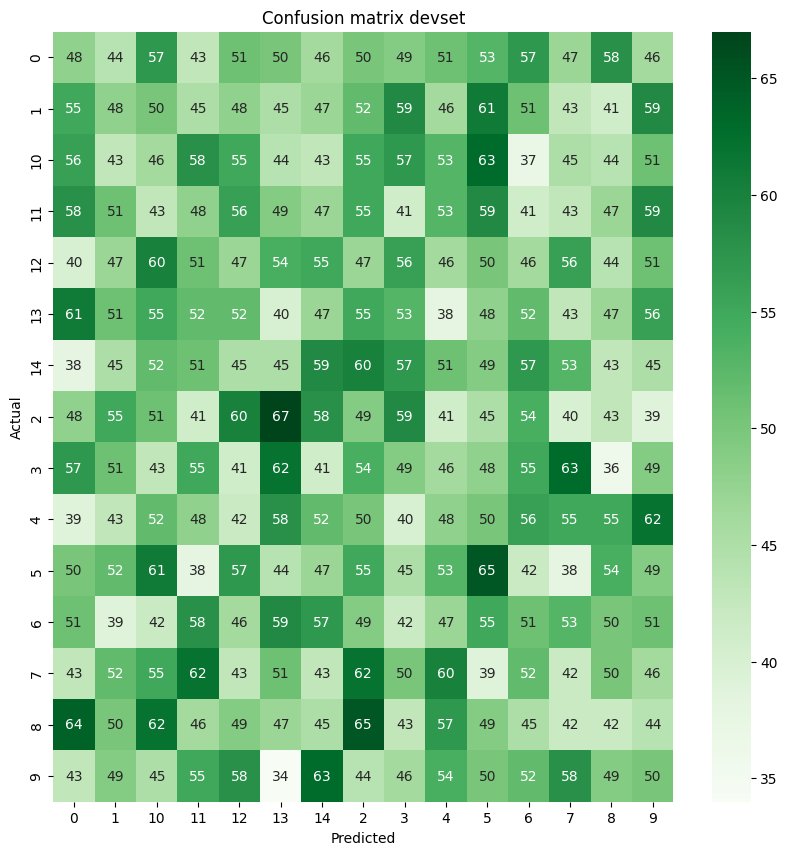

In [20]:
# Dự đoán
val_Y_pred = model.predict(val_generator)
val_y_pred = np.argmax(val_Y_pred, axis=1)

# Labels
val_labels = val_generator.class_indices
val_labels = dict((v, k) for k, v in val_labels.items())
val_predictions = [val_labels[k] for k in val_y_pred]

# Thực tế
val_y_test = val_generator.classes
val_true_labels = [val_labels[k] for k in val_y_test]

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions, labels=list(val_labels.values()))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(val_labels.values()), yticklabels=list(val_labels.values()), cmap='Greens')
plt.title('Confusion matrix devset')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
print(classification_report(val_true_labels, val_predictions))

              precision    recall  f1-score   support

           0       0.06      0.06      0.06       750
           1       0.07      0.06      0.07       750
          10       0.06      0.06      0.06       750
          11       0.06      0.06      0.06       750
          12       0.06      0.06      0.06       750
          13       0.05      0.05      0.05       750
          14       0.08      0.08      0.08       750
           2       0.06      0.07      0.06       750
           3       0.07      0.07      0.07       750
           4       0.06      0.06      0.06       750
           5       0.08      0.09      0.08       750
           6       0.07      0.07      0.07       750
           7       0.06      0.06      0.06       750
           8       0.06      0.06      0.06       750
           9       0.07      0.07      0.07       750

    accuracy                           0.07     11250
   macro avg       0.07      0.07      0.07     11250
weighted avg       0.07   

821/821 ━━━━━━━━━━━━━━━━━━━━ 687s 837ms/step


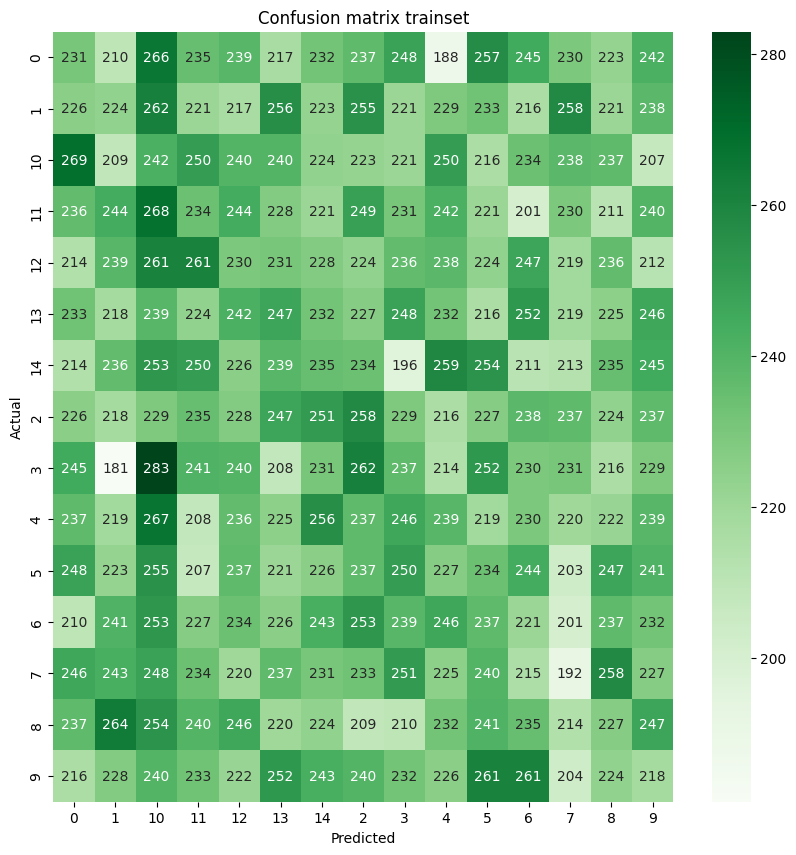

In [22]:
# Dự đoán
train_Y_pred = model.predict(train_generator)
train_y_pred = np.argmax(train_Y_pred, axis=1)

# Labels
train_labels = train_generator.class_indices
train_labels = dict((v, k) for k, v in train_labels.items())
train_predictions = [train_labels[k] for k in train_y_pred]

# Thực tế
train_y_test = train_generator.classes
train_true_labels = [train_labels[k] for k in train_y_test]

# Confusion matrix
cm = confusion_matrix(train_true_labels, train_predictions, labels=list(train_labels.values()))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(train_labels.values()), yticklabels=list(train_labels.values()), cmap='Greens')
plt.title('Confusion matrix trainset')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
print(classification_report(train_true_labels, train_predictions))

              precision    recall  f1-score   support

           0       0.07      0.07      0.07      3500
           1       0.07      0.06      0.06      3500
          10       0.06      0.07      0.07      3500
          11       0.07      0.07      0.07      3500
          12       0.07      0.07      0.07      3500
          13       0.07      0.07      0.07      3500
          14       0.07      0.07      0.07      3500
           2       0.07      0.07      0.07      3500
           3       0.07      0.07      0.07      3500
           4       0.07      0.07      0.07      3500
           5       0.07      0.07      0.07      3500
           6       0.06      0.06      0.06      3500
           7       0.06      0.05      0.06      3500
           8       0.07      0.06      0.07      3500
           9       0.06      0.06      0.06      3500

    accuracy                           0.07     52500
   macro avg       0.07      0.07      0.07     52500
weighted avg       0.07   